In [1]:
from os import listdir
import os.path as op
from glob import glob

import numpy as np
from scipy.stats import zscore, norm, chi2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import seaborn as sns
sns.set()

import mne
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper
from mne.viz import plot_topomap

In [2]:
def add_bad_labels(raw, subj_id):
    """Label the the bad channels in a raw object"""

    bads = dict(
        DXFTLCJA=[[], ['MLF67-1609', 'MLF66-1609', 'MLT14-1609', 'MRO24-1609',
                       'MRP23-1609', 'MRP22-1609', 'MRP34-1609', 'MRT35-1609',
                       'MRT15-1609', 'MRP57-1609', 'MRP56-1609', 'MRO14-1609',
                       'MLT44-1609', 'MRO34-1609']],
        BQBBKEBX=[[], ['MLF67-1609', 'MLF66-1609', 'MLT14-1609', 'MRO24-1609',
                       'MRP23-1609', 'MRP22-1609', 'MRP34-1609', 'MRT35-1609',
                       'MRT15-1609', 'MRP57-1609', 'MRP56-1609', 'MRO14-1609',
                       'MLT44-1609']],
        JBGAZIEO=[[], ['MLF25-1609']],
        QGFMDSZY=[['MLP41-1609'], []],
        ZDIAXRUW=[['MRF61-1609', 'MRC62-1609', 'MRC15-1609', 'MRO41-1609',
                   'MRO53-1609', 'MRT41-1609', 'MRT42-1609', 'MRT43-1609'],
                  ['MRC55-1609']]
    )

    # mark bad channels; maintain symmetry of channels across sessions
    if subj_id in bads:
        for bad_sess in bads[subj_id]:
            for bad_ch in bad_sess:
                if bad_ch not in raw.info['bads']:
                    raw.info['bads'].append(bad_ch)


def fit_ssd(data, info):
    """Alpha-band Spatio-Spectral Decomposition (SSD) from raw data"""
    freqs_sig = 9, 14  # alpha
    freqs_noise = 8, 15  # alpha
    # freqs_sig = 15, 29  # beta
    # freqs_noise = 14, 30  # beta
    # freqs_sig = 35, 45  # gamma
    # freqs_noise = 30, 50  # gamma

    ssd = SSD(info=info,
              reg='oas',
              sort_by_spectral_ratio=True,
              filt_params_signal=dict(l_freq=freqs_sig[0],
                                      h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1,
                                      h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0],
                                     h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1,
                                     h_trans_bandwidth=1))
    data_filtered = ssd.fit_transform(X=data)
    return data_filtered, ssd

In [3]:
def analysis(subj_id):
    # read in both sessions belonging to a single subject
    raw_sessions = list()
    alpha_sess = list()
    session_fnames = sorted(glob(op.join(data_dir, subj_id + '*')))

    fig_alpha_ssd, axes = plt.subplots(1, 2, constrained_layout=True)
    colors = ['grey', 'orange']
    
    ssd_weights = list()
    for sess_idx, fname in enumerate(session_fnames):
        raw = mne.io.read_raw_ctf(fname, verbose=False)
        raw.load_data()
        add_bad_labels(raw, subj_id)  # modifies Raw object in-place
        raw.pick_types(meg=True, eeg=False, ref_meg=False)
        raw.filter(l_freq=3., h_freq=55)
        # raw._data = zscore(raw._data, axis=1)
        raw._data -= raw._data.mean()
        raw._data /= raw._data.std()
        raw.resample(sfreq=500)
        raw_sessions.append(raw)
        
        filtered_data, ssd = fit_ssd(raw.get_data(), raw.info)
        
        im, _ = plot_topomap(ssd.patterns_[0], ssd.info,
                             axes=axes[sess_idx], show=False)
        plt.colorbar(im, ax=axes[sess_idx], fraction=0.05)
        ssd_weights.append(ssd.patterns_[0])
    ssd_weights_diff = ssd_weights[1] - ssd_weights[0]
    
    ssd_norm = np.linalg.norm(ssd_weights_diff)
    
    return fig_alpha_ssd, ssd_norm

def analysis_2(subj_id):
    # read in both sessions belonging to a single subject
    raw_sessions = list()
    alpha_sess = list()
    session_fnames = sorted(glob(op.join(data_dir, subj_id + '*')))

    fig_alpha_ssd, axes = plt.subplots(1, 2, constrained_layout=True)
    colors = ['grey', 'orange']
    
    ssd_weights = list()
    for sess_idx, fname in enumerate(session_fnames):
        raw = mne.io.read_raw_ctf(fname, verbose=False)
        raw.load_data()
        add_bad_labels(raw, subj_id)  # modifies Raw object in-place
        raw.pick_types(meg=True, eeg=False, ref_meg=False)
        raw.filter(l_freq=3., h_freq=55)
        # raw._data = zscore(raw._data, axis=1)
        raw._data -= raw._data.mean()
        raw._data /= raw._data.std()
        raw.resample(sfreq=500)
        raw_sessions.append(raw)
        
        filtered_data, ssd = fit_ssd(raw.get_data(), raw.info)
        
        im, _ = plot_topomap(ssd.patterns_[0], ssd.info, axes=axes[sess_idx],
                             vmin=-.1, vmax=.1, show=False)
        plt.colorbar(im, ax=axes[sess_idx], fraction=0.05)
        ssd_weights.append(ssd.patterns_[0])
    
    ssd_std_diff = ssd_weights[1].std() - ssd_weights[0].std()
    
    ssd_weights_diff = ssd_weights[1] - ssd_weights[0]
    ssd_weights_diff_flip = ssd_weights[1] + ssd_weights[0]
    ssd_norm = min(np.linalg.norm(ssd_weights_diff), np.linalg.norm(ssd_weights_diff_flip))
    
    fig_alpha_ssd.tight_layout()
    
    return fig_alpha_ssd, ssd_std_diff, ssd_norm

In [4]:
n_jobs = 10
n_subjs = 36

data_dir = '/home/ryan/Documents/datasets/MDD_ketamine_2022'
# data_dir = '/Volumes/THORPE/MDD_ketamine_2022'
subj_ids = list({fname[:8] for fname in listdir(data_dir)})
print(subj_ids)

subj_ids = subj_ids[:n_subjs]

out = Parallel(n_jobs=n_jobs)(delayed(analysis_2)(subj_id) for subj_id in subj_ids)

['BYADLMJH', 'YGSUCZFD', 'WRODLVBY', 'JBGAZIEO', 'YDCCVVKE', 'EYZQADGL', 'TISSNJCK', 'IEKAAXXL', 'GFRLKCRT', 'UPWNKWXJ', 'CKTSVVFM', 'MIVYRJFO', 'LUXESHXT', 'RASMDGZN', 'TCTIPUPB', 'DXFTLCJA', 'CEYAXQYB', 'VATJUZCI', 'PHMOFCIB', 'EGQFCISZ', 'YWRNZYIR', 'IRGXULEZ', 'TTUJUWXV', 'ZDIAXRUW', 'QGFMDSZY', 'MIMGQLOB', 'BQBBKEBX', 'SJHBZREE', 'OLEGXGZO', 'YIWMSUPM', 'WWIZIWSJ', 'VWRRHGZE', 'CECMHHYP', 'SPIVRRSB', 'WKQIVMBY', 'YFLOQXEZ']
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs...
Reading 0 ... 299999  =      0.000 ...   249.999 secs.

Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- F

Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 1.1e+02 (2.2e-16 eps * 271 dim * 1.8e+15  max singular value)
    Using tolerance 1.2e+02 (2.2e-16 eps * 271 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 271
    MAG: rank 271 computed from 271 data channels with 0 projectors
    Using tolerance 1.2e+02 (2.2e-16 eps * 271 dim * 1.9e+15  max singular value)
    Estimated rank (mag): 271
    MAG: rank 271 computed from 271 data channels with 0 projectors
    Estimated rank (mag): 271
    MAG: rank 271 computed from 271 data channels with 0 projectors
    Using tolerance 1e+02 (2.2e-16 eps * 272 dim * 1.7e+15  

Removing 5 compensators from info because not all compensation channels were picked.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 1981 samples (1.651 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower 

Setting up band-pass filter from 9 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 8 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- F

Computing rank from data with rank=None
Reducing data rank from 272 -> 272
    Using tolerance 42 (2.2e-16 eps * 271 dim * 6.9e+14  max singular value)
Done.
Estimating covariance using OAS
    Estimated rank (mag): 271
    MAG: rank 271 computed from 271 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 271 -> 271
Done.
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Done.
    Using tolerance 64 (2.2e-16 eps * 271 dim * 1.1e+15  max singular value)
    Estimated rank (mag): 271
    MAG: rank 271 computed from 271 data channels with 0 projectors
    Using tolerance 44 (2.2e-16 eps * 271 dim * 7.3e+14  max singular value)
    Using tolerance 65 (2.2e-16 eps * 272 dim * 1.1e+15  max singular value)
Effective window size : 1.000 (s)
    Estimated rank (mag): 271
    MAG: rank 271 computed from 271 data channels with 0 projectors
    Estimated rank (mag): 272
    MAG: rank 27

TypeError: cannot pickle 'kiwisolver.Solver' object

<IPython.core.display.Javascript object>


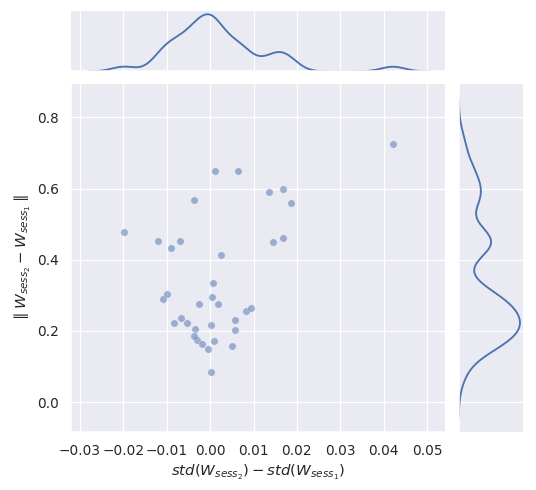

In [64]:
_, ssd_std_diffs, ssd_norms = zip(*out)

ax = sns.kdeplot(data=ssd_norms, bw_adjust=1.)
sns.rugplot(data=ssd_norms, ax=ax)

g = sns.JointGrid(x=ssd_std_diffs, y=ssd_norms)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot, bw_adjust=.5)
g.ax_joint.set_xlabel(r'$std(W_{sess_2})-std(W_{sess_1})$')
g.ax_joint.set_ylabel(r'$\parallel W_{sess_2}-W_{sess_1}\parallel$')
g.fig.tight_layout() 

#sns.kdeplot(data=ssd_norms, bw_adjust=1.)
#sns.rugplot(data=ssd_norms, ax=ax)

['YFLOQXEZ', 'CKTSVVFM', 'DXFTLCJA', 'WRODLVBY', 'SPIVRRSB', 'YDCCVVKE', 'BQBBKEBX', 'WWIZIWSJ', 'QGFMDSZY', 'CECMHHYP', 'EGQFCISZ', 'VATJUZCI', 'ZDIAXRUW', 'SJHBZREE', 'BYADLMJH', 'UPWNKWXJ', 'PHMOFCIB', 'MIVYRJFO', 'IRGXULEZ', 'TISSNJCK', 'GFRLKCRT', 'YIWMSUPM', 'YWRNZYIR', 'IEKAAXXL', 'EYZQADGL', 'CEYAXQYB', 'OLEGXGZO', 'VWRRHGZE', 'JBGAZIEO', 'TCTIPUPB', 'YGSUCZFD', 'RASMDGZN', 'MIMGQLOB', 'TTUJUWXV', 'WKQIVMBY', 'LUXESHXT']


/home/ryan/anaconda3/envs/hnn_core/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


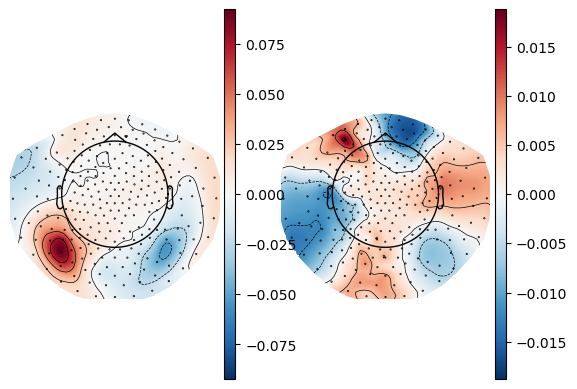

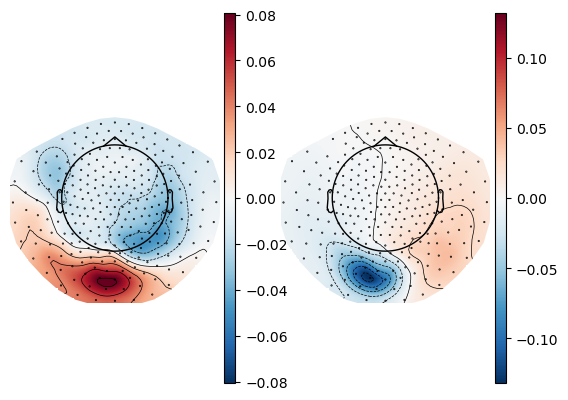

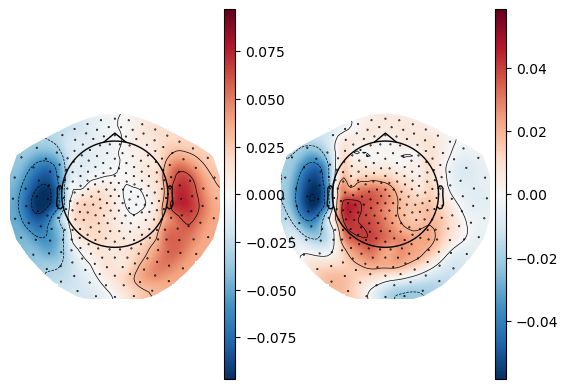

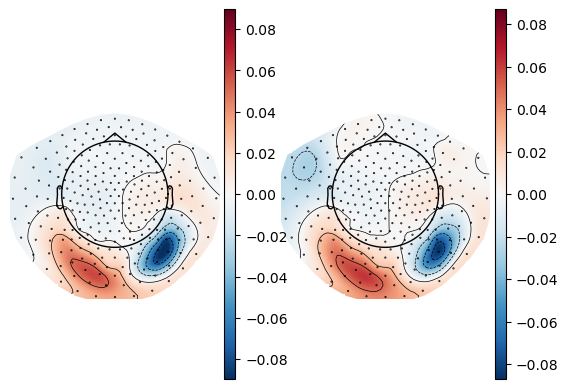

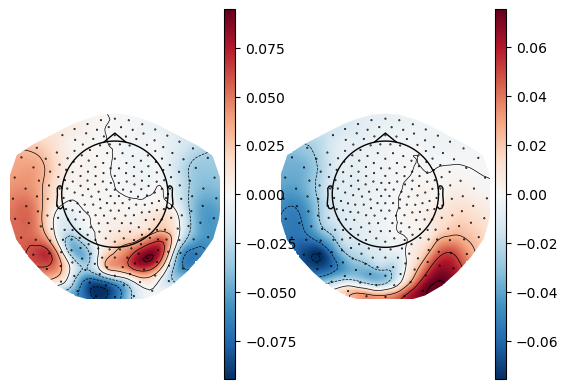

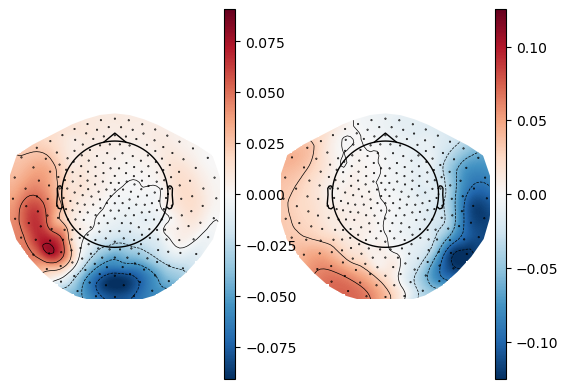

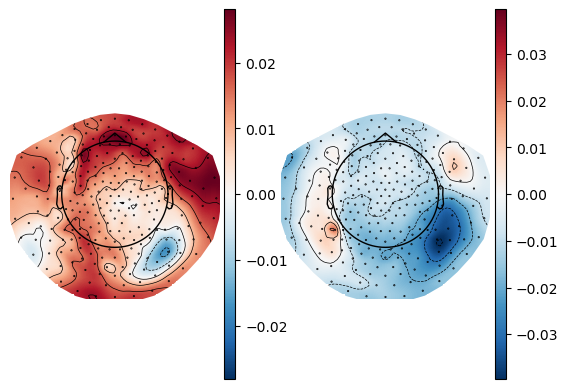

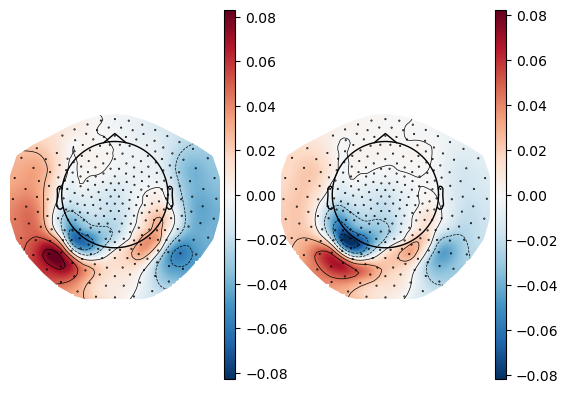

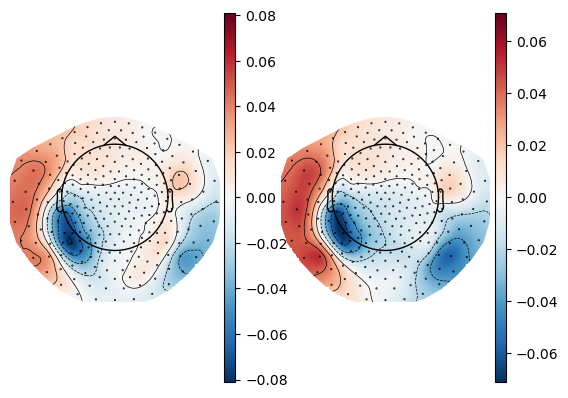

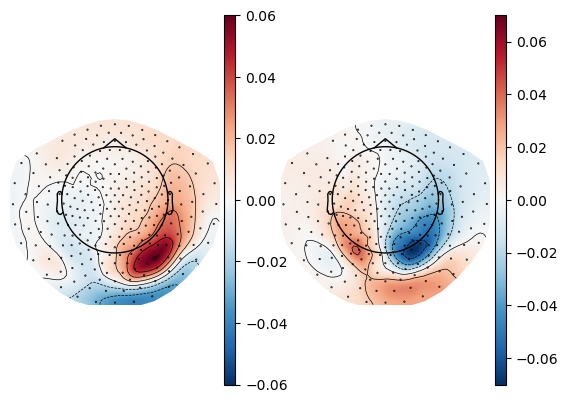

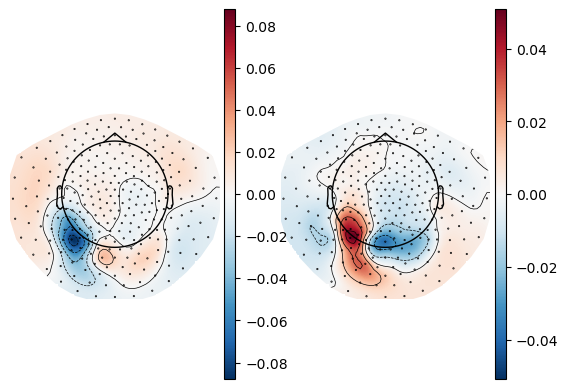

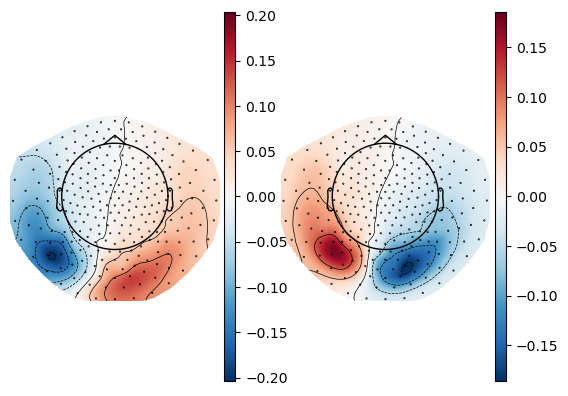

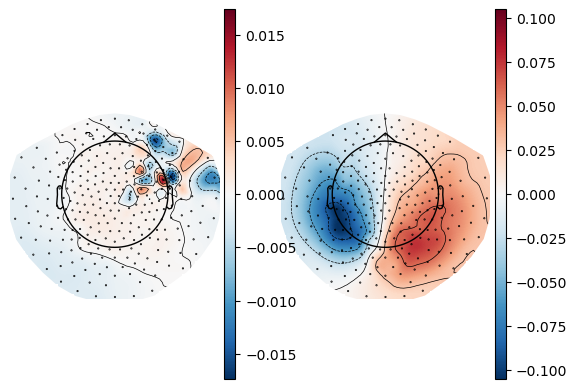

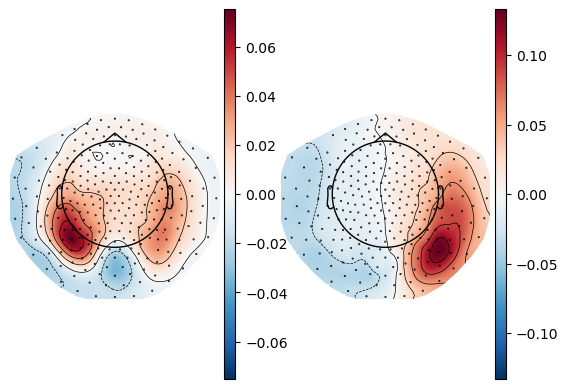

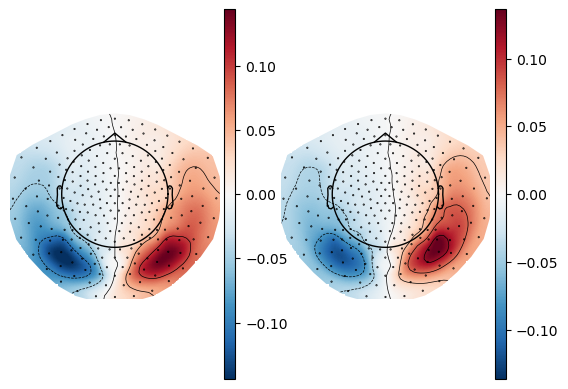

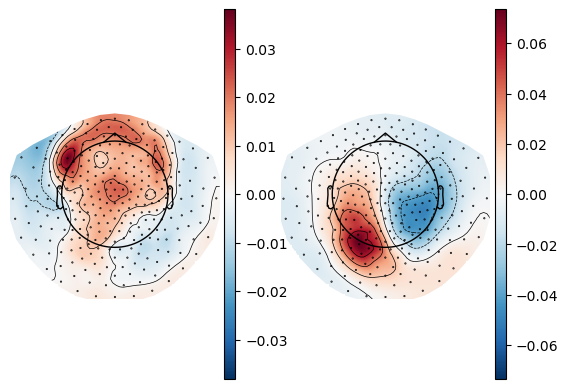

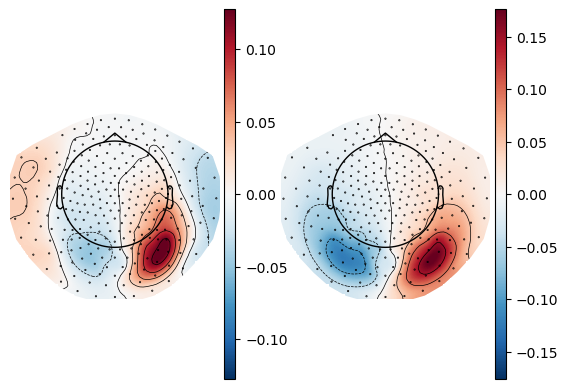

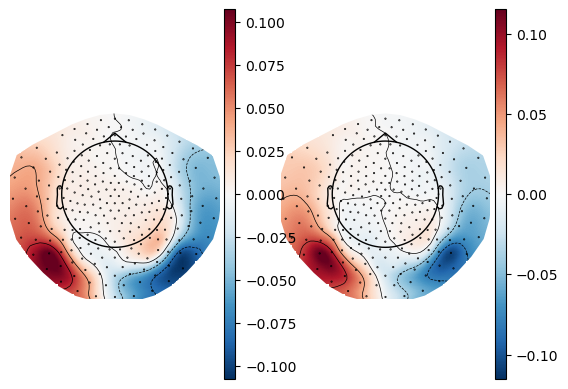

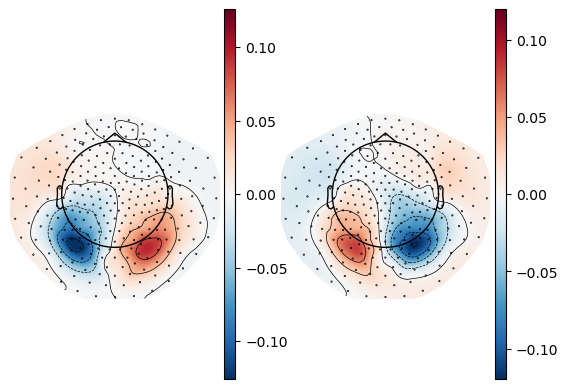

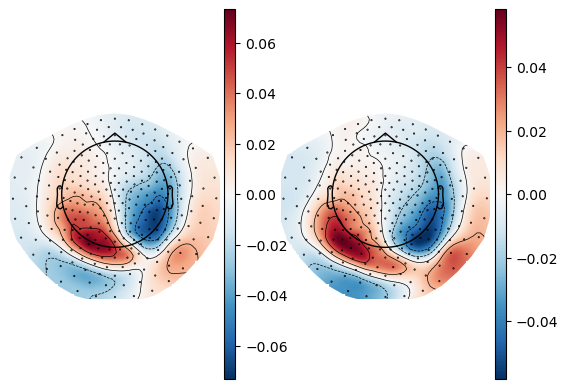

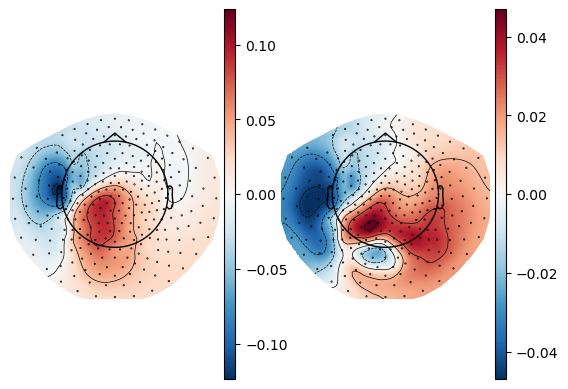

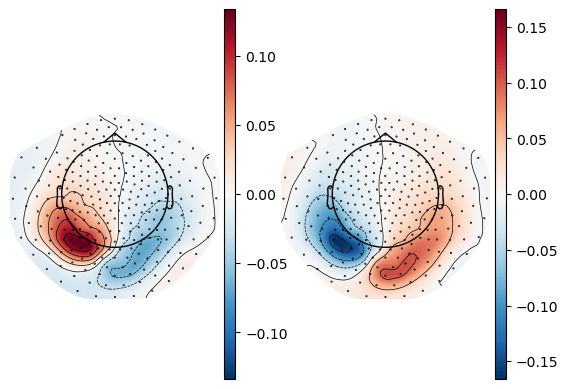

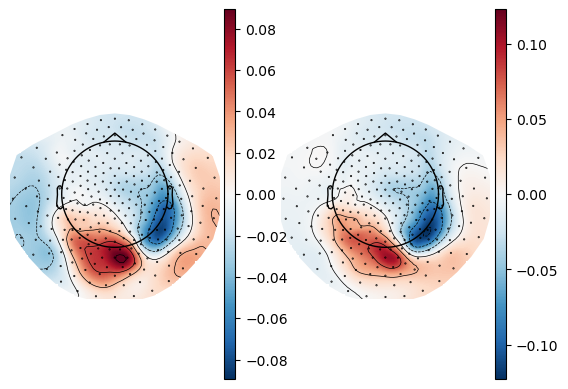

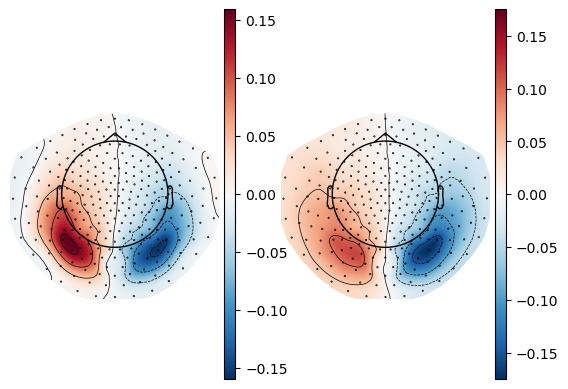

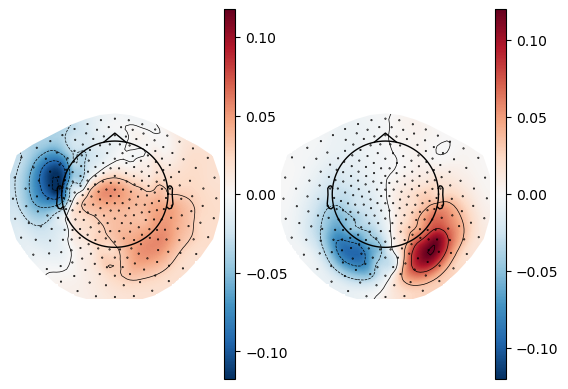

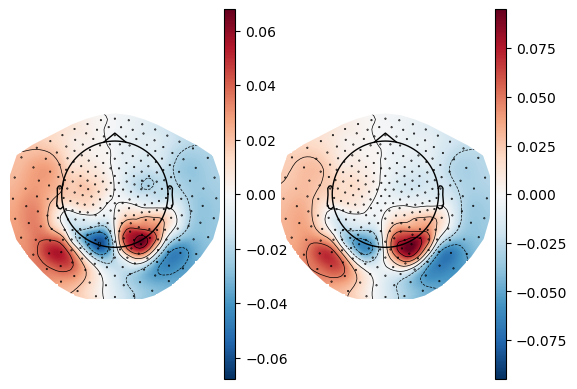

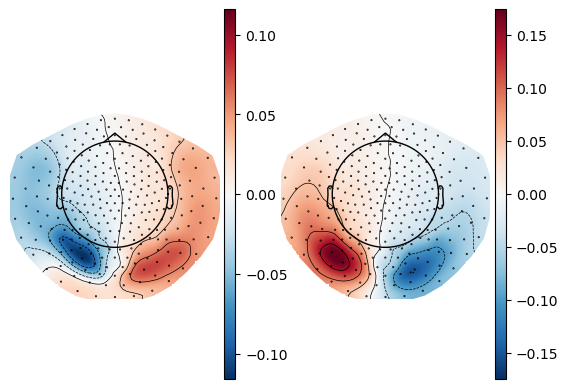

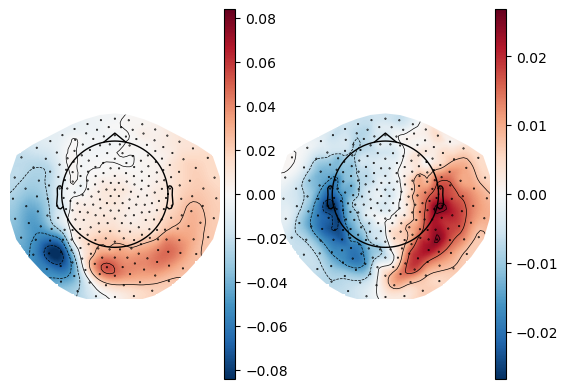

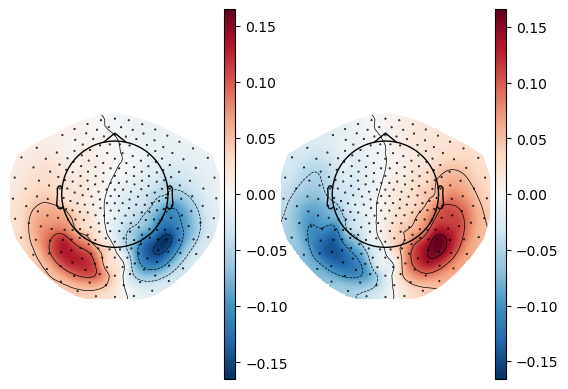

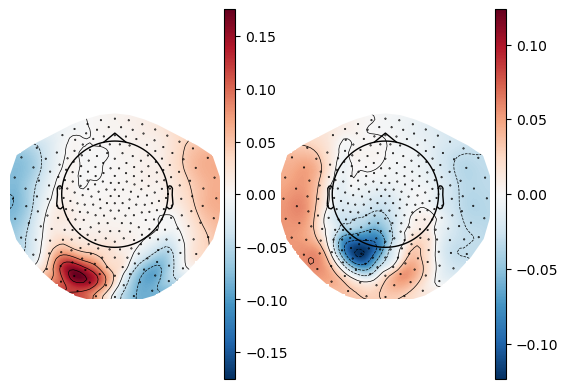

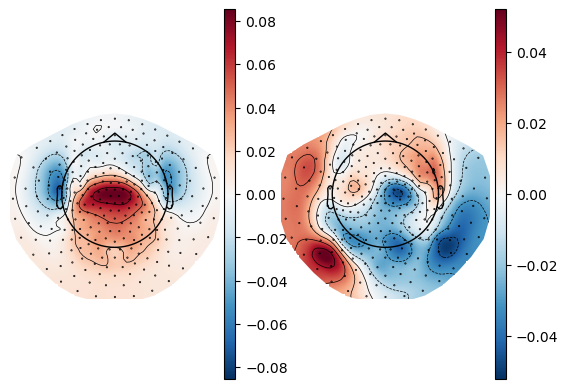

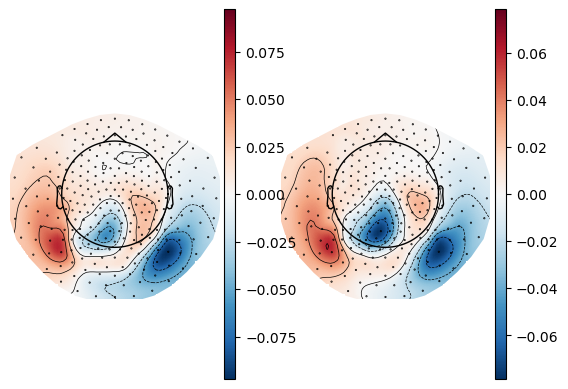

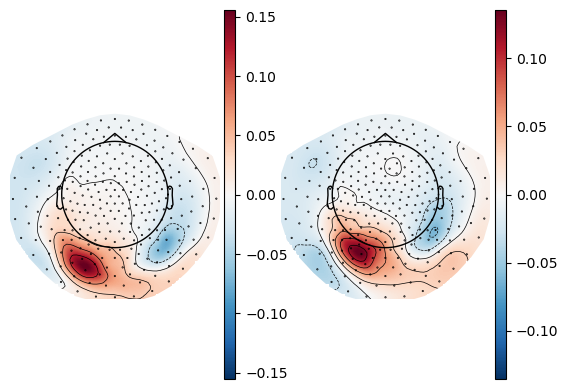

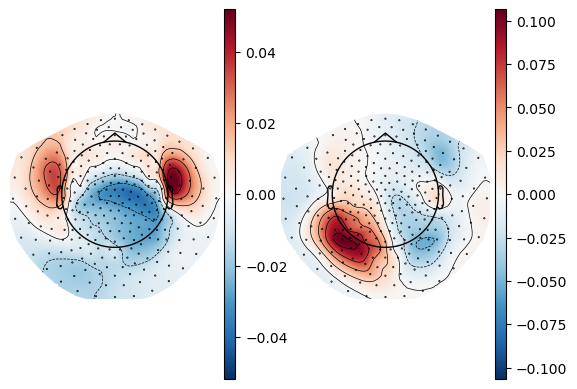

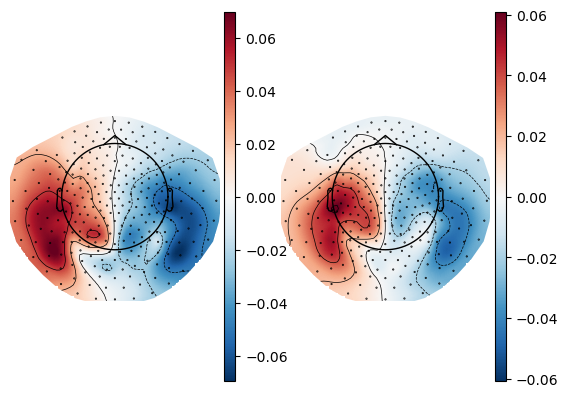

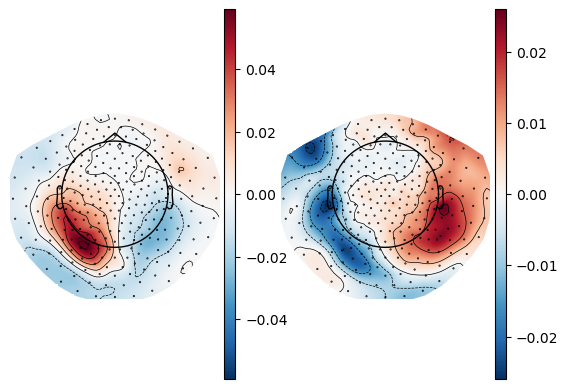

In [4]:
n_jobs = 6
n_subjs = 36

data_dir = '/home/ryan/Documents/datasets/MDD_ketamine_2022'
# data_dir = '/Volumes/THORPE/MDD_ketamine_2022'
subj_ids = list({fname[:8] for fname in listdir(data_dir)})
print(subj_ids)

subj_ids = subj_ids[:n_subjs]

out = Parallel(n_jobs=n_jobs)(delayed(analysis)(subj_id) for subj_id in subj_ids)

<AxesSubplot:ylabel='Density'>

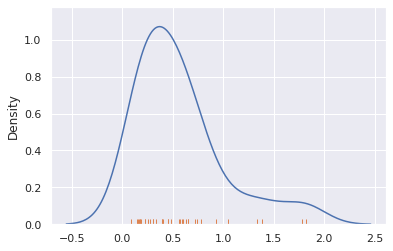

In [6]:
_, ssd_norms = zip(*out)
fig, ax = plt.subplots(1, 1)

sns.kdeplot(data=ssd_norms, bw_adjust=1., ax=ax)
sns.rugplot(data=ssd_norms, ax=ax)